In [1]:
import concurrent.futures
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# metrics
from sklearn.metrics import *

# visuals.
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ARK's daily trades
TRADES_DATE = "2021-02-16"
DELTA = 1

year, month, day = TRADES_DATE.split("-")
files = list(Path(f"./trades/").glob(f"{TRADES_DATE}_ARK_TRADES.csv"))
if len(files)>1:
    raise ValueError("more than 1 file for the given date")
    
trades = pd.read_csv(files[0])
trades.columns = trades.columns.map(lambda x:x.lower())
trades.sort_values("ticker", inplace=True)
print(trades.shape)
trades.head()

(33, 8)


,fund,date,direction,ticker,cusip,company,shares,% of etf
2,ARKG,2021-02-16,Buy,ABBV,00287Y109,ABBVIE INC,121900,0.1005
23,ARKQ,2021-02-16,Buy,ACIC,049284102,ATLAS CREST INVESTMENT CORP,372574,0.1285
16,ARKQ,2021-02-16,Buy,AMZN,023135106,AMAZON.COM INC,1875,0.1509
31,ARKW,2021-02-16,Sell,API,00851L103,AGORA INC,25621,0.0287
26,ARKQ,2021-02-16,Sell,AVAV,008073108,AEROVIRONMENT INC,6115,0.0205


In [3]:
# open prices of traded stocks
open_configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Open"} for ticker in trades["ticker"].unique()] # on ark's trade date

def parallel_fetch_daily_data(config):
    try:
        # fetch daily market data from yahoo finance
        df = web.get_data_yahoo(config["ticker"], start=config["date"], end=config["date"])[[config["on"]]]
        df["ticker"] = config["ticker"]
        df.drop_duplicates(inplace=True)
        return df
    except Exception as e:
        print(e)


open_prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    open_prices.extend(executor.map(parallel_fetch_daily_data, open_configs))
open_prices = pd.concat(open_prices)
open_prices.reset_index(inplace=True)
open_prices.set_index("ticker", inplace=True)
print(open_prices.shape)
open_prices.head()

(33, 2)


,Date,Open
ticker,,
ABBV,2021-02-16,105.330002
ACIC,2021-02-16,14.870000
AMZN,2021-02-16,3254.050049
API,2021-02-16,111.500000
AVAV,2021-02-16,138.220001


In [4]:
# net & volume of trades (assume on open price)
net = trades.copy()[["ticker", "shares", "direction"]]
net["shares"] = net.apply(lambda row:row["shares"] if row["direction"]=="Buy" else -row["shares"], axis=1)
net = net.groupby("ticker").sum()

net = net.join(open_prices, how="inner") # link to price

net["signal"] = net["shares"].apply(lambda x: "Buy" if x>0 else "Sell")
net["volume"] = net["shares"] * net["Open"]
net["abs_volume"] = abs(net["volume"])

net = net[~net.index.duplicated(keep='first')]
net.sort_values("abs_volume", ascending=False, inplace=True)
print(net.shape)
net.style.bar(subset=["abs_volume"], color='lightgreen')

(32, 6)


,shares,Date,Open,signal,volume,abs_volume
ticker,,,,,,
PLTR,1560200,2021-02-16 00:00:00,30.020000,Buy,46837204.714203,46837204.714203
SPLK,-119650,2021-02-16 00:00:00,174.000000,Sell,-20819100.000000,20819100.000000
Z,-67864,2021-02-16 00:00:00,200.990005,Sell,-13639985.732788,13639985.732788
SGFY,360361,2021-02-16 00:00:00,36.799999,Buy,13261284.525066,13261284.525066
TDY,32600,2021-02-16 00:00:00,395.279999,Buy,12886127.960205,12886127.960205
ABBV,121900,2021-02-16 00:00:00,105.330002,Buy,12839727.223206,12839727.223206
TSM,-71667,2021-02-16 00:00:00,141.610001,Sell,-10148763.913742,10148763.913742
SE,-31931,2021-02-16 00:00:00,281.920013,Sell,-9001987.948761,9001987.948761
PSTG,-265044,2021-02-16 00:00:00,29.379999,Sell,-7786992.497566,7786992.497566


In [5]:
FUTURE_DATE = datetime.strptime(TRADES_DATE, '%Y-%m-%d') + timedelta(days=DELTA)

# on ark's trades date
configs = [{"ticker":ticker, "date":TRADES_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()]
# future date
configs.extend([{"ticker":ticker, "date":FUTURE_DATE, "on":"Adj Close"} for ticker in trades["ticker"].unique()])

prices = [] # list of dfs
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    prices.extend(executor.map(parallel_fetch_daily_data, configs))
prices = pd.concat(prices)
print(prices.shape)
prices.tail(3)

No data fetched for symbol ADYEN using YahooDailyReader
No data fetched for symbol 1833 using YahooDailyReader
No data fetched for symbol 3690 using YahooDailyReader
No data fetched for symbol 1833 using YahooDailyReader
No data fetched for symbol 3690 using YahooDailyReader
No data fetched for symbol ADYEN using YahooDailyReader
(34, 2)


,Adj Close,ticker
Date,,
2021-02-11,1463.310059,SHOP
2021-02-11,169.960007,SPLK
2021-02-11,50.700001,SSYS


In [6]:
returns = [] # actual price changes
gg = prices.groupby("ticker")
for g in gg.groups:
    gdf = gg.get_group(g)
    if len(gdf)>2:
        raise ValueError("records exceed 2. can only compare 2 records")
    ticker_return = gdf["Adj Close"].pct_change().loc[FUTURE_DATE]
    returns.append({
        "ticker":g,
        "return":ticker_return,
        "actual":"Buy" if ticker_return > 0 else "Sell"
    })
returns = pd.DataFrame(returns)
returns.set_index("ticker", inplace=True)
returns.head(3)

,return,actual
ticker,,
API,0.046967,Buy
CDNA,-0.007077,Sell
EXPC,0.033848,Buy


In [7]:
df = net.join(returns).sort_values("abs_volume", ascending=False)
df.style.apply(
    lambda row:
    [
        'background-color: #f2344c' if row["actual"]!=row["signal"] else 'background-color: #4c864d'
        for i in range(len(df.columns))
    ]
    , axis=1,
)

,shares,Date,Open,signal,volume,abs_volume,return,actual
ticker,,,,,,,,
REGN,71033,2021-02-10 00:00:00,493.429993,Buy,35049812.669739,35049812.669739,-0.001384,Sell
RHHBY,485288,2021-02-10 00:00:00,43.830002,Buy,21270173.928589,21270173.928589,0.001145,Buy
SPLK,-114882,2021-02-10 00:00:00,172.809998,Sell,-19852758.139526,19852758.139526,0.011546,Buy
NVS,178586,2021-02-10 00:00:00,92.000000,Buy,16429912.000000,16429912.000000,0.007871,Buy
SHOP,10437,2021-02-10 00:00:00,1448.010010,Buy,15112880.471924,15112880.471924,0.000609,Buy
PCAR,71400,2021-02-10 00:00:00,100.309998,Buy,7162133.825684,7162133.825684,-0.010040,Sell
CDNA,-76084,2021-02-10 00:00:00,90.508003,Sell,-6886210.918121,6886210.918121,-0.007077,Sell
KMTUY,71564,2021-02-10 00:00:00,29.920000,Buy,2141194.885460,2141194.885460,-0.004017,Sell
API,-17639,2021-02-10 00:00:00,100.000000,Sell,-1763900.000000,1763900.000000,0.046967,Buy


<Figure size 720x504 with 0 Axes>

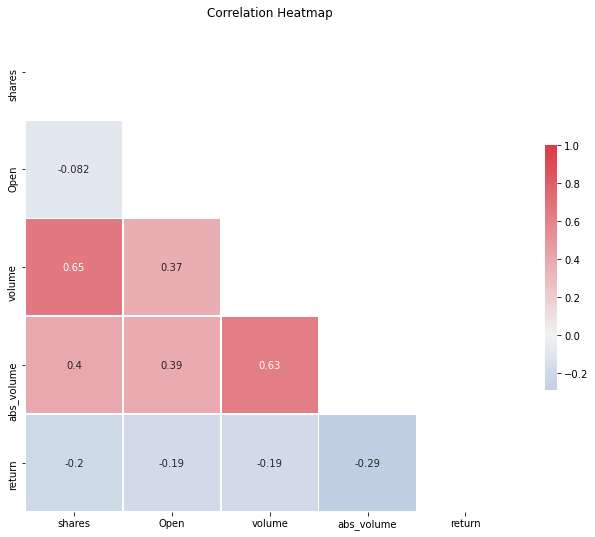

In [8]:
# correlation heatmap
plt.figure(figsize=(10,7))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title("Correlation Heatmap");

              precision    recall  f1-score   support

         Buy       0.60      0.50      0.55        12
        Sell       0.14      0.20      0.17         5

    accuracy                           0.41        17
   macro avg       0.37      0.35      0.36        17
weighted avg       0.47      0.41      0.43        17



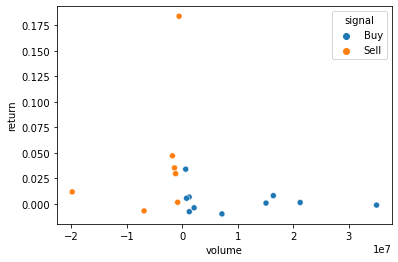

In [9]:
print(classification_report(df["actual"], df["signal"]))
sns.scatterplot(x=df["volume"], y=df["return"], hue=df["signal"])

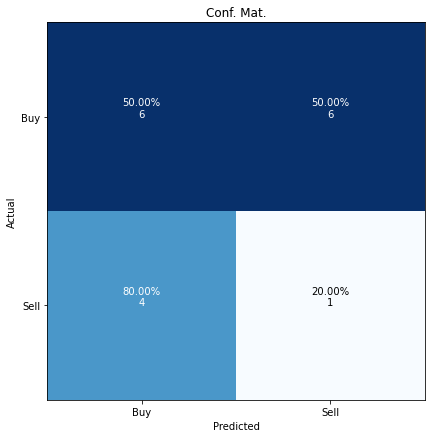

In [10]:
def plot_confusion_matrix_(cm, target_names, title='Conf. Mat.', normalize=True, saveit=False, showit=True):
    import itertools
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     thresh = cm_norm.max() / 1.5 if normalize else cm.max() / 2
    thresh =  cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, 
                     "{:0.2f}%\n{:,}".format(100*cm_norm[i, j], cm[i, j]),
                     horizontalalignment="center",
                     # color="white" if cm_norm[i, j] > thresh else "black",
                     color="white" if cm[i, j] > thresh else "black",
                    )
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    if saveit:
        plt.savefig(fname=saveit)
    if showit:
        plt.show()
plot_confusion_matrix_(confusion_matrix(df["actual"], df["signal"]), ["Buy", "Sell"])